<a href="https://colab.research.google.com/github/harshavardhangadila/Training-Neural-networks-with-Keras/blob/main/Part%201/G_Custom_Dropout_and_Custom_Regularizer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Import required libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, regularizers
import numpy as np
import matplotlib.pyplot as plt

# Set random seed for reproducibility
tf.random.set_seed(42)


In [2]:
# Load dataset
(x_train_full, y_train_full), (x_test, y_test) = keras.datasets.fashion_mnist.load_data()

# Normalize pixel values
x_train_full = x_train_full.astype("float32") / 255.0
x_test = x_test.astype("float32") / 255.0

# Expand dimensions for Conv2D
x_train_full = np.expand_dims(x_train_full, axis=-1)
x_test = np.expand_dims(x_test, axis=-1)

# Subset data
x_train, y_train = x_train_full[:4500], y_train_full[:4500]
x_val, y_val = x_train_full[4500:5000], y_train_full[4500:5000]

print("Training samples:", x_train.shape)
print("Validation samples:", x_val.shape)


29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Training samples: (4500, 28, 28, 1)
Validation samples: (500, 28, 28, 1)


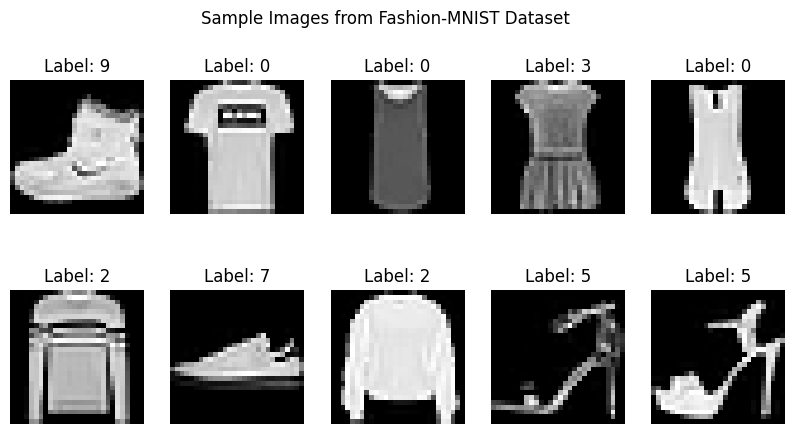

In [3]:
# Plot sample images
plt.figure(figsize=(10, 5))
for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(x_train[i].squeeze(), cmap='gray')
    plt.title(f"Label: {y_train[i]}")
    plt.axis('off')
plt.suptitle("Sample Images from Fashion-MNIST Dataset")
plt.show()


In [4]:
# Define a custom Dropout Layer (drops entire feature maps randomly)
class SpatialDropout(layers.Layer):
    def __init__(self, rate):
        super(SpatialDropout, self).__init__()
        self.rate = rate

    def call(self, inputs, training=None):
        if not training:
            return inputs
        noise_shape = (tf.shape(inputs)[0], 1, 1, tf.shape(inputs)[-1])
        return tf.nn.dropout(inputs, rate=self.rate, noise_shape=noise_shape)


In [5]:
# Define a custom regularizer that penalizes large weights
class ThresholdL1Regularizer(regularizers.Regularizer):
    def __init__(self, threshold=0.1, l1=1e-3):
        self.threshold = threshold
        self.l1 = l1

    def __call__(self, x):
        penalty = tf.reduce_sum(tf.abs(tf.where(tf.abs(x) > self.threshold, x, tf.zeros_like(x))))
        return self.l1 * penalty

    def get_config(self):
        return {'threshold': self.threshold, 'l1': self.l1}


In [8]:
# Define the CNN model with custom dropout and custom regularizer
def build_custom_model():
    inputs = keras.Input(shape=x_train.shape[1:])

    # First Conv block
    x = layers.Conv2D(32, (3, 3), padding='same',
                      kernel_regularizer=ThresholdL1Regularizer(threshold=0.2, l1=1e-3))(inputs)
    x = SpatialDropout(0.3)(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPooling2D()(x)

    # Second Conv block
    x = layers.Conv2D(64, (3, 3), padding='same',
                      kernel_regularizer=ThresholdL1Regularizer(threshold=0.2, l1=1e-3))(x)
    x = SpatialDropout(0.3)(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPooling2D()(x)

    # Fully Connected layers
    x = layers.Flatten()(x)
    x = layers.Dense(128, activation='relu',
                     kernel_regularizer=ThresholdL1Regularizer(threshold=0.2, l1=1e-3))(x)
    outputs = layers.Dense(10, activation='softmax')(x)

    model = keras.Model(inputs, outputs)

    # Compile the model
    model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    # Return the compiled model
    return model


In [9]:
# Build the model
model_custom = build_custom_model()

# Train the model
history_custom = model_custom.fit(
    x_train, y_train,
    validation_data=(x_val, y_val),
    epochs=25,
    batch_size=64,
    verbose=2
)


Epoch 1/25
71/71 - 12s - 167ms/step - accuracy: 0.6144 - loss: 1.0533 - val_accuracy: 0.8220 - val_loss: 0.5225
Epoch 2/25
71/71 - 0s - 6ms/step - accuracy: 0.7827 - loss: 0.5947 - val_accuracy: 0.8480 - val_loss: 0.4299
Epoch 3/25
71/71 - 1s - 9ms/step - accuracy: 0.8122 - loss: 0.5164 - val_accuracy: 0.8640 - val_loss: 0.3823
Epoch 4/25
71/71 - 1s - 7ms/step - accuracy: 0.8298 - loss: 0.4663 - val_accuracy: 0.8640 - val_loss: 0.3712
Epoch 5/25
71/71 - 1s - 9ms/step - accuracy: 0.8391 - loss: 0.4433 - val_accuracy: 0.8800 - val_loss: 0.3432
Epoch 6/25
71/71 - 0s - 5ms/step - accuracy: 0.8569 - loss: 0.4074 - val_accuracy: 0.8860 - val_loss: 0.3131
Epoch 7/25
71/71 - 0s - 4ms/step - accuracy: 0.8667 - loss: 0.3798 - val_accuracy: 0.9040 - val_loss: 0.2937
Epoch 8/25
71/71 - 1s - 9ms/step - accuracy: 0.8756 - loss: 0.3578 - val_accuracy: 0.9060 - val_loss: 0.2903
Epoch 9/25
71/71 - 1s - 8ms/step - accuracy: 0.8818 - loss: 0.3485 - val_accuracy: 0.9080 - val_loss: 0.2716
Epoch 10/25
71/7

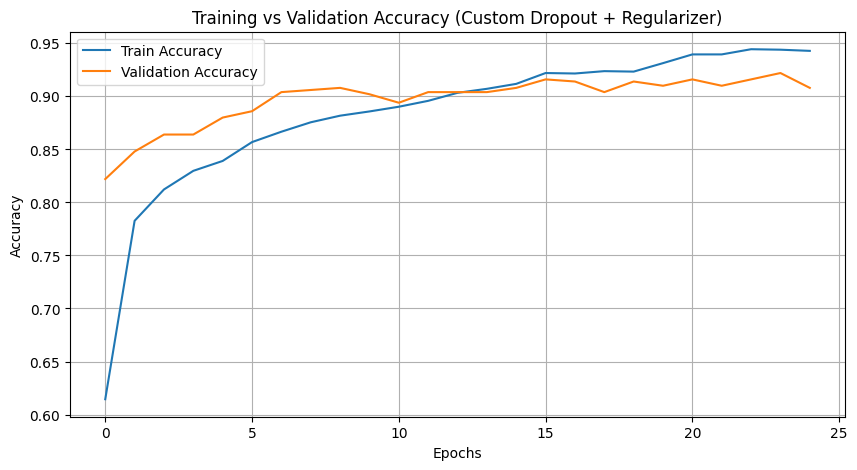

In [10]:
# Plot training and validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(history_custom.history['accuracy'], label='Train Accuracy')
plt.plot(history_custom.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training vs Validation Accuracy (Custom Dropout + Regularizer)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()


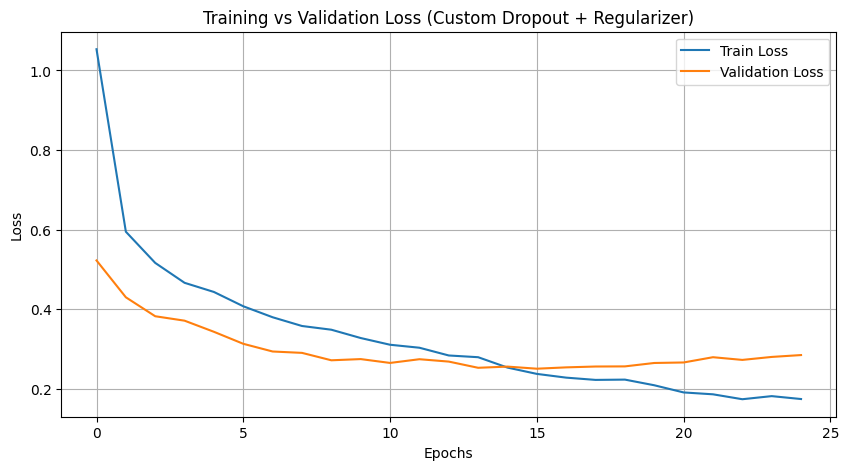

In [11]:
# Plot training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(history_custom.history['loss'], label='Train Loss')
plt.plot(history_custom.history['val_loss'], label='Validation Loss')
plt.title('Training vs Validation Loss (Custom Dropout + Regularizer)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


In [12]:
# Print the final validation accuracy
print(f"Final Validation Accuracy: {history_custom.history['val_accuracy'][-1]:.4f}")


Final Validation Accuracy: 0.9080


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


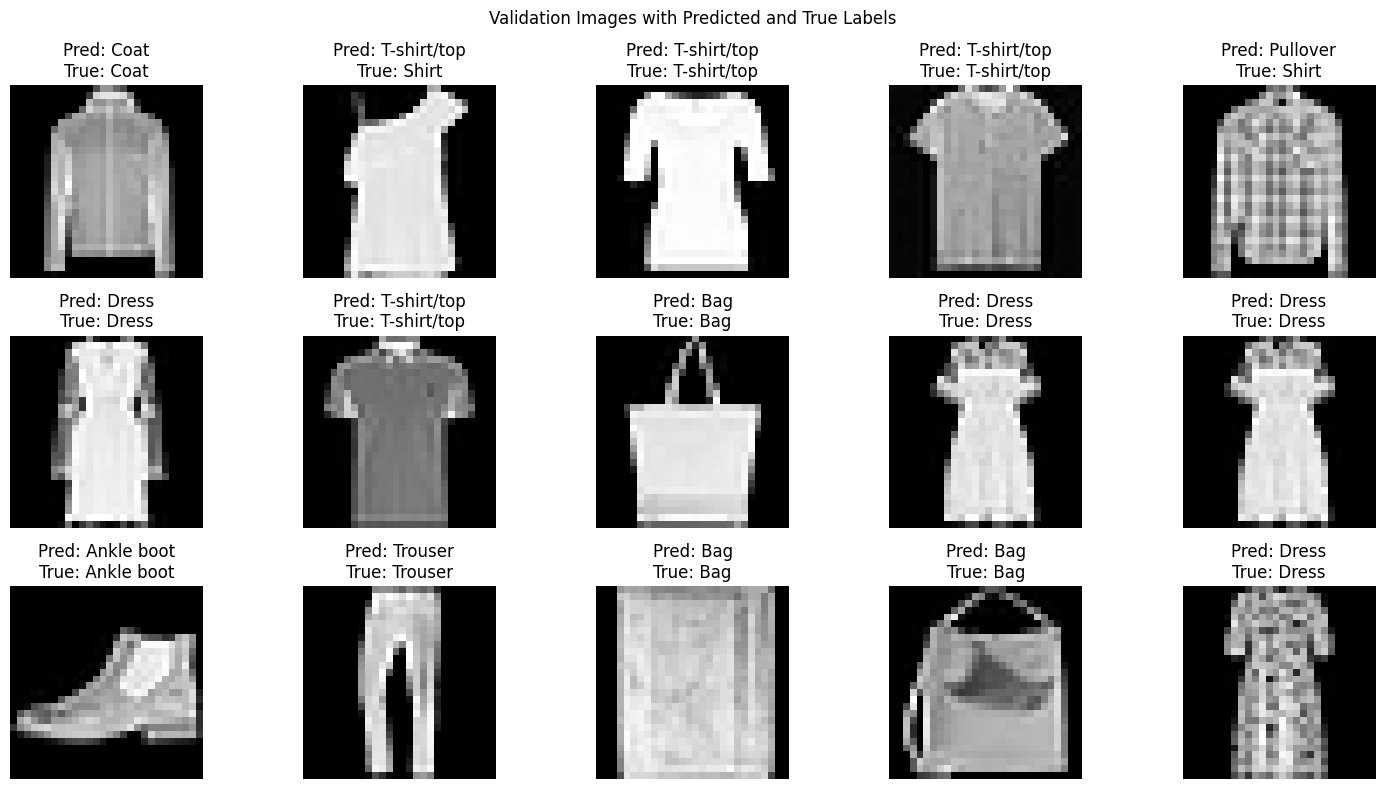

In [14]:
# Class labels for Fashion MNIST dataset
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

# Make predictions on validation set
y_pred_probs = model_custom.predict(x_val)
y_pred_classes = np.argmax(y_pred_probs, axis=1)

# Plot 15 random images with predictions
plt.figure(figsize=(15, 8))
for i in range(15):
    idx = np.random.randint(0, x_val.shape[0])
    plt.subplot(3, 5, i + 1)
    plt.imshow(x_val[idx].squeeze(), cmap='gray')
    plt.title(f"Pred: {class_names[y_pred_classes[idx]]}\nTrue: {class_names[y_val[idx]]}")
    plt.axis('off')

plt.suptitle("Validation Images with Predicted and True Labels")
plt.tight_layout()
plt.show()
